In [3]:
import razor.flow as rf
from razor.api import datasources, engines, project_space_path
import logging
import time
import typing as typ
import numpy as np
import pandas as pd

logger = logging.getLogger()


/usr/local/lib/python3.7/dist-packages/snowflake/connector/options.py:78: UserWarning: You have an incompatible version of 'pyarrow' installed (3.0.0), please install a version that adheres to: 'pyarrow<0.18.0,>=0.17.0; extra == "pandas"'
  warn_incompatible_dep('pyarrow', _installed_pyarrow_version.version, _expected_pyarrow_version)


ImportError: cannot import name 'engines' from 'razor.api' (/usr/local/lib/python3.7/dist-packages/razor/api/__init__.py)

In [2]:
def drop_col(df):
    return df.drop(['x_temp'], axis=1)

@rf.block
class STDIn:
    filename: str
    out_ds: rf.Output[typ.Any] = rf.Output(transport=rf.KafkaTransport)

    def run(self):
        df = pd.read_parquet(project_space_path(self.filename))

        df['x_temp'] = np.nan
        logger.info(df.head())
        self.out_ds.put(df)


@rf.block
class STDOut:
    in_ds: typ.Any
    out_filename: str

    def run(self):
        logger.info(self.in_ds.shape)
        self.in_ds.to_parquet(project_space_path(self.out_filename), index=False)
        

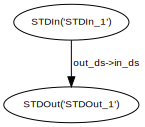

In [3]:
config = {'cores': 1, 'ram': 4096}


size = '10MB'
ip_filename = "/data/sdk_testbench/input_data/dummy_"+size+"_df.parquet"
op_filename = "/data/sdk_testbench/output_data/tc_09.parquet"

std_in = STDIn(filename=ip_filename)
# std_in.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])
std_in.out_ds = rf.Output.set(adapter=drop_col)

std_out = STDOut(in_ds=std_in.out_ds, out_filename=op_filename)
# std_out.executor = rf.ContainerExecutor(cores=config['cores'], memory=config['ram'])

pipeline = rf.Pipeline(name='adapter_atomic_kafka_transport', targets=[std_out])
pipeline.show()

In [4]:
def create_pipeline():
    return pipeline